#### For Colab

In [1]:
"""
function ClickConnect(){
    console.log("Working");
    document.querySelector("colab-toolbar-button").click() 
}
var i = setInterval(ClickConnect, 900000)
clearInterval(i)
"""

'\nfunction ClickConnect(){\n    console.log("Working");\n    document.querySelector("colab-toolbar-button").click() \n}\nvar i = setInterval(ClickConnect, 900000)\nclearInterval(i)\n'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
drive_dir = '/content/drive/My Drive/MAGMA: Summarization/'
data_dir = '/content/drive/My Drive/MAGMA: Summarization/corpora/karger_books/'

#### Init

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import re
import pandas as pd
import textwrap

import random

## **Config**

In [5]:
MODEL = 'bart'

SEED = 7

# Output directory
OUTPUT_PATH = drive_dir+'summarization/compare_results/'

# Types of Rouge measures
R_TYPES = ['precision', 'recall', 'fmeasure']

## **Function Definition**

In [6]:
def plot_rouge(df, method, rouge, submethod=None):
    if submethod is None : submethod = method

    fig, ax = plt.subplots(figsize=(10, 6))
    plt.boxplot(
        [df[rouge+'_'+r].tolist() for r in R_TYPES],
        widths=0.4,
        patch_artist=False,
        meanline=True,
        showmeans=True)
    ax.grid(True, axis='y', alpha=0.7, linestyle='--')
    ax.set_title(method.title()+' '+rouge, fontsize='xx-large')
    ax.set_ylabel(rouge, fontsize='x-large')
    ax.set_xticklabels(R_TYPES, fontsize='x-large')
    plt.savefig(OUTPUT_PATH+method+'/'+submethod+'_'+MODEL+'_'+rouge+'.png')
    plt.show()

In [7]:
def plot_compare_rouge(df_list, method_list, rouge, folder=None):
    num_df = len(df_list)
    
    from matplotlib.cm import get_cmap
    color = get_cmap('tab10')(range(num_df))

    def set_box_color(b, c):
        for k in b.keys():
            plt.setp(b[k], color=c)

    xticks = np.array(.7*num_df*np.arange(1, len(R_TYPES)+1))

    fig, ax = plt.subplots(figsize=(12, 8))
    box_plt_list = [plt.boxplot(
        [df[rouge+'_'+r].tolist() for r in R_TYPES],
        positions= xticks+var,
        sym='+',
        widths=0.4,
        patch_artist=False,
        meanline=True,
        showmeans=True)\
        for df, var in zip(df_list, np.linspace(-0.15*num_df, 0.15*num_df, num_df))]

    for i, bp in enumerate(box_plt_list):
        set_box_color(bp, color[i])
        plt.plot([], c=color[i], label=method_list[i])
    plt.legend()

    ax.grid(True, axis='y', alpha=0.7, linestyle='--')
    ax.set_title(' vs '.join(method_list).title()+' '+rouge, fontsize='xx-large')
    ax.set_ylabel(rouge, fontsize='x-large')
    plt.xticks(xticks, R_TYPES, fontsize='x-large')
    if folder is not None:
        plt.savefig(OUTPUT_PATH+folder+'/'+' vs '.join(method_list)+'_'+MODEL+'_'+rouge+'.png')
    else:
        plt.savefig(OUTPUT_PATH+' vs '.join(method_list)+'_'+MODEL+'_'+rouge+'.png')
    plt.show()

In [8]:
def chapter_avg(df):
    return df.groupby('bullets').mean()

def chapter_best(df):
    return df.groupby('bullets').max()

In [9]:
def print_text_bull_summ(t, b, s):
    print('\nText:')
    print(textwrap.fill(t, 150))
    print('\nBullets:')
    print(textwrap.fill(b, 150))
    print('\nPredicted Summary:')
    print(textwrap.fill(s, 150))
    print()
    print(''.join(['#']*150))
    print(''.join(['#']*150))
    print('\n')

def print_random_summaries(df, ids, summary_col='summary'):
    df_sort = df.sort_index()

    for id in ids:
        text = df_sort.loc[id].text
        bullets = df_sort.loc[id].bullets
        summary = df_sort.loc[id][summary_col]
        
        if isinstance(text, str):
            print(id)
            print_text_bull_summ(text, bullets, summary)

        elif isinstance(text, list):
            n_bull = 1
            for c, b, s in zip(text, bullets, summary):
                print(id, 'bullet', n_bull)
                print_text_bull_summ(c, b, s)

                n_bull += 1
            print(id)
            print('\nAll Bullets:')
            print(textwrap.fill(' '.join(bullets), 150))
            print('\nAll Predicted Summary:')
            print(textwrap.fill(' '.join(summary), 150))
            print()
            print(''.join(['#']*150))
            print(''.join(['#']*150))
            print('\n')

        else:
            # we are considering a chapter divided in chunks
            # for each chunk we have a different summary which
            # tries to resembles the bullets of the entire cpt
            text = text.tolist()
            bullets = bullets.tolist()[0]
            summary = summary.tolist()

            n_chunk = 1
            for c, s in zip(text, summary):
                print(id, 'chunk', n_chunk)
                print_text_bull_summ(c, bullets, s)
                n_chunk += 1

## **Chunk Chapter (Baseline)**

#### Loading data

In [10]:
input_path = drive_dir+'summarization/baseline_output/'
df_base = pd.read_csv(input_path+'df_summ_'+MODEL+'.csv')
df_base = df_base.set_index(['book', 'chapter'])

#### Rouge

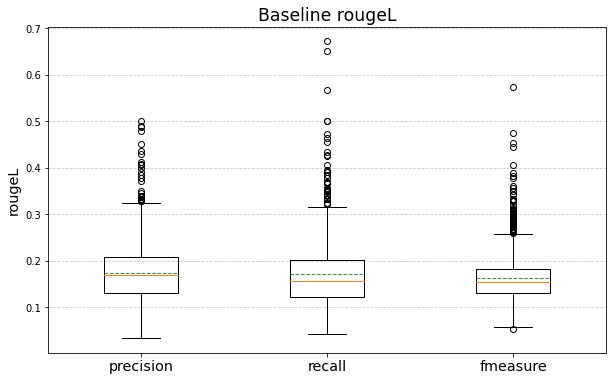

In [11]:
plot_rouge(df_base, 'baseline', 'rougeL')

#### Print Random Summaries

In [12]:
random.seed(SEED)
RANDOM_IDS = random.sample(df_base.index.tolist(), 3)
print(RANDOM_IDS)

[(9781908541994, 'ch05'), (9781908541437, 'ch_9'), (9781910797181, 'ch01')]


In [13]:
print_random_summaries(df_base, RANDOM_IDS)

(9781908541994, 'ch05') chunk 1

Text:
Topical therapy . Topical therapy is useful in nearly all acne regimens . mild localized acne . moderate acne; in combination with, and following,
oral therapy . maintenance therapy; after stopping systemic agents for severe acne . Mild acne that consists of open and closed comedones and/or few
inflammatory lesions is amenable to topical therapy using agents such as salicylic acid, retinoids, azelaic acid, benzoyl peroxide (BPO) and topical
antibiotics . The use of topical antibiotics as single agents for acne is discouraged because of the potential for the development of bacterial
resistance . Topical retinoids are useful as first-line agents and topical antibiotics, when used, should be combined with BPO, ideally as a fixed-
dose combination product to enhance adherence . Topical agents differ in their efficacy against the various etiologic factors . Retinoids, azelaic
acid and BPO are effective for comedones and inflammatory acne . Topical anti

Summaries are accurate. A summary from one chunk may not cover all information present in the bullets, since the info is not present in the chunk a priori. And the generated summary can be more verbose than the bullets.

However, merging summaries from all chunks can cover better the information of the bullets. This would result in a much longer summary, but all information would be accurate.

## **Only TextRank**

#### Loading data

In [14]:
input_path = drive_dir+'summarization/textrank_output/'
df_tr = pd.read_csv(input_path+'df_textrank_summ.csv')
df_tr = df_tr.set_index(['book', 'chapter'])

df_tr.bullets = df_tr.bullets.map(eval)
df_tr.bullets = df_tr.bullets.map(lambda b: ' '.join(b))
df_tr = df_tr.rename(columns={'textrank_summary': 'summary'})

#### Rouge

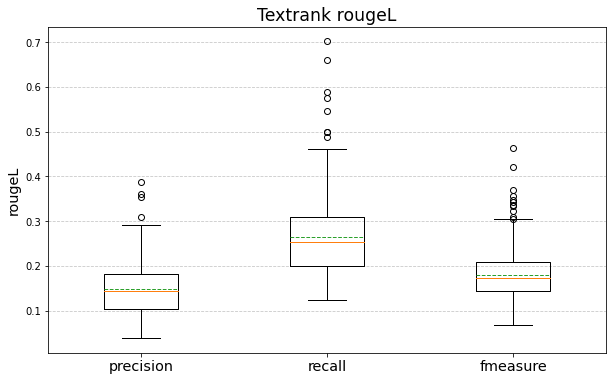

In [15]:
plot_rouge(df_tr, 'textrank', 'rougeL')

#### Print Random Summaries

In [16]:
print_random_summaries(df_tr, RANDOM_IDS)

(9781908541994, 'ch05')

Text:
Topical therapy . Topical therapy is useful in nearly all acne regimens . mild localized acne . moderate acne; in combination with, and following,
oral therapy . maintenance therapy; after stopping systemic agents for severe acne . Mild acne that consists of open and closed comedones and/or few
inflammatory lesions is amenable to topical therapy using agents such as salicylic acid, retinoids, azelaic acid, benzoyl peroxide (BPO) and topical
antibiotics . The use of topical antibiotics as single agents for acne is discouraged because of the potential for the development of bacterial
resistance . Topical retinoids are useful as first-line agents and topical antibiotics, when used, should be combined with BPO, ideally as a fixed-
dose combination product to enhance adherence . Topical agents differ in their efficacy against the various etiologic factors . Retinoids, azelaic
acid and BPO are effective for comedones and inflammatory acne . Topical antibiotics 

In this case, since this method is extractive, generated summaries sometimes are not very coherent. Sometimes the summary are accurate, sometimes are about something totally different from the bullets.

## **Topic Modeling**

### **LDA**

#### Loading data

In [17]:
input_path = drive_dir+'summarization/topic_modeling_output/'
df_lda_redu = pd.read_csv(input_path+'df_lda_redu.csv')
df_lda_redu = df_lda_redu.set_index(['book', 'chapter'])

df_lda_summ = pd.read_csv(input_path+'df_lda_summ_'+MODEL+'.csv')
df_lda_summ = df_lda_summ.set_index(['book', 'chapter'])

#### Rouge

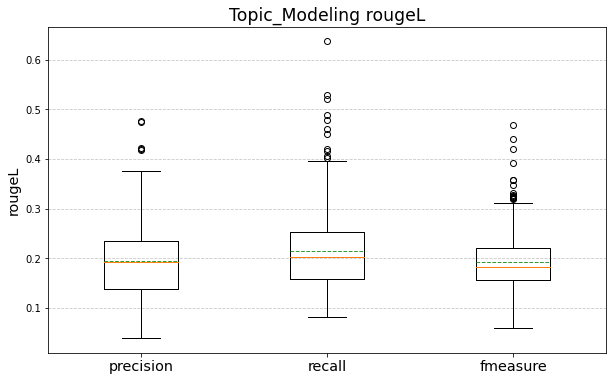

In [18]:
plot_rouge(df_lda_summ, 'topic_modeling', 'rougeL', submethod='lda')

#### Print Random Summaries

In [19]:
print_random_summaries(df_lda_summ, RANDOM_IDS, 'lda_summary')

(9781908541994, 'ch05')

Text:
Topical therapy . Topical therapy is useful in nearly all acne regimens . mild localized acne . moderate acne; in combination with, and following,
oral therapy . maintenance therapy; after stopping systemic agents for severe acne . Mild acne that consists of open and closed comedones and/or few
inflammatory lesions is amenable to topical therapy using agents such as salicylic acid, retinoids, azelaic acid, benzoyl peroxide (BPO) and topical
antibiotics . The use of topical antibiotics as single agents for acne is discouraged because of the potential for the development of bacterial
resistance . Topical retinoids are useful as first-line agents and topical antibiotics, when used, should be combined with BPO, ideally as a fixed-
dose combination product to enhance adherence . Topical agents differ in their efficacy against the various etiologic factors . Retinoids, azelaic
acid and BPO are effective for comedones and inflammatory acne . Topical antibiotics 

Summaries are more accurate than TextRank since this method introduces abstraction. However, because the first level is extractive, sometimes phrases are not collated in a very abstract way.

Moreover, it can be noticed that sometimes the topic model does not keep some information that is present in the bullets. Thus, the generated summaries do not include some information in the bullets and generate info which is not present.

### **LSI**

#### Loading data

In [20]:
input_path = drive_dir+'summarization/topic_modeling_output/'
df_lsi_redu = pd.read_csv(input_path+'df_lsi_redu.csv')
df_lsi_redu = df_lsi_redu.set_index(['book', 'chapter'])

df_lsi_summ = pd.read_csv(input_path+'df_lsi_summ_'+MODEL+'.csv')
df_lsi_summ = df_lsi_summ.set_index(['book', 'chapter'])

#### Rouge

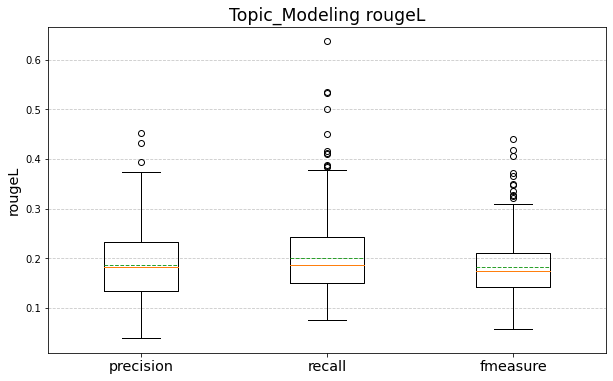

In [21]:
plot_rouge(df_lsi_summ, 'topic_modeling', 'rougeL', submethod='lsi')

#### Print Random Summaries

In [22]:
print_random_summaries(df_lsi_summ, RANDOM_IDS, 'lsi_summary')

(9781908541994, 'ch05')

Text:
Topical therapy . Topical therapy is useful in nearly all acne regimens . mild localized acne . moderate acne; in combination with, and following,
oral therapy . maintenance therapy; after stopping systemic agents for severe acne . Mild acne that consists of open and closed comedones and/or few
inflammatory lesions is amenable to topical therapy using agents such as salicylic acid, retinoids, azelaic acid, benzoyl peroxide (BPO) and topical
antibiotics . The use of topical antibiotics as single agents for acne is discouraged because of the potential for the development of bacterial
resistance . Topical retinoids are useful as first-line agents and topical antibiotics, when used, should be combined with BPO, ideally as a fixed-
dose combination product to enhance adherence . Topical agents differ in their efficacy against the various etiologic factors . Retinoids, azelaic
acid and BPO are effective for comedones and inflammatory acne . Topical antibiotics 

### **TextRank**

#### Loading data

In [23]:
input_path = drive_dir+'summarization/topic_modeling_output/'
df_textrank_redu = pd.read_csv(input_path+'df_textrank_redu.csv')
df_textrank_redu = df_textrank_redu.set_index(['book', 'chapter'])

df_textrank_summ = pd.read_csv(input_path+'df_textrank_summ_'+MODEL+'.csv')
df_textrank_summ = df_textrank_summ.set_index(['book', 'chapter'])

#### Rouge

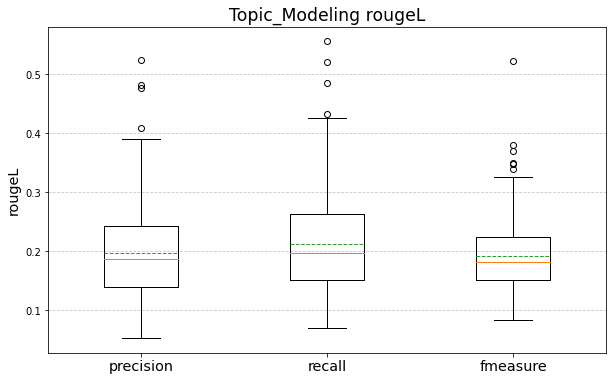

In [24]:
plot_rouge(df_textrank_summ, 'topic_modeling', 'rougeL', submethod='textrank')

#### Print Random Summaries

In [25]:
print_random_summaries(df_textrank_summ, RANDOM_IDS, 'textrank_summary')

(9781908541994, 'ch05')

Text:
Topical therapy . Topical therapy is useful in nearly all acne regimens . mild localized acne . moderate acne; in combination with, and following,
oral therapy . maintenance therapy; after stopping systemic agents for severe acne . Mild acne that consists of open and closed comedones and/or few
inflammatory lesions is amenable to topical therapy using agents such as salicylic acid, retinoids, azelaic acid, benzoyl peroxide (BPO) and topical
antibiotics . The use of topical antibiotics as single agents for acne is discouraged because of the potential for the development of bacterial
resistance . Topical retinoids are useful as first-line agents and topical antibiotics, when used, should be combined with BPO, ideally as a fixed-
dose combination product to enhance adherence . Topical agents differ in their efficacy against the various etiologic factors . Retinoids, azelaic
acid and BPO are effective for comedones and inflammatory acne . Topical antibiotics 

### **LDA vs LSI vs TextRank**

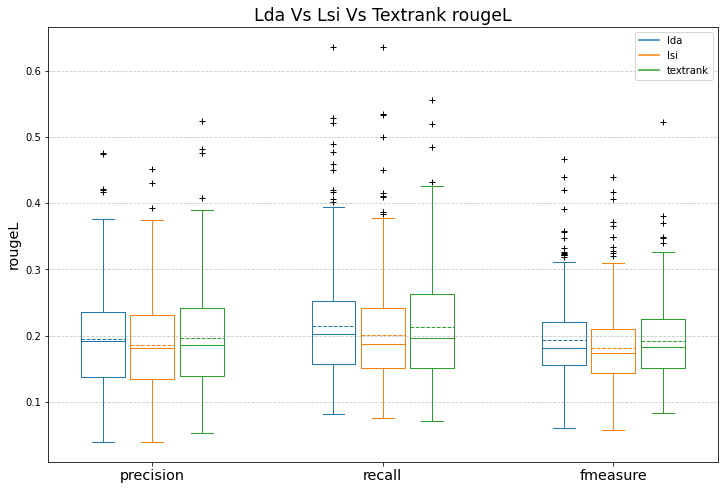

In [26]:
plot_compare_rouge(
    [df_lda_summ, df_lsi_summ, df_textrank_summ],
    ['lda', 'lsi', 'textrank'],
    'rougeL',
    folder='topic_modeling')

### **Summary vs Reduction**

We can notice that summaries always improve over reductions. Moreover, considering the recall, one can see that on average the reductions get a Rouge L score higher than 0.3. This means the main points in the bullets are not completely lost during the reduction phase.

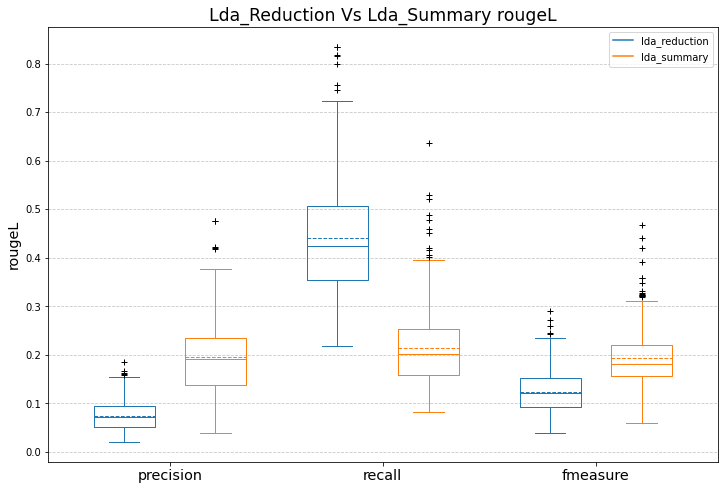

In [27]:
plot_compare_rouge(
    [df_lda_redu, df_lda_summ],
    ['lda_reduction', 'lda_summary'],
    'rougeL',
    folder = 'topic_modeling')

## **Merge or Chunk**

#### Loading data

In [28]:
input_path = drive_dir+'summarization/moc_output/'
df_moc = pd.read_csv(input_path+'df_summ_'+MODEL+'.csv')
df_moc = df_moc.set_index(['book', 'chapter', 'merge'])

#### Rouge

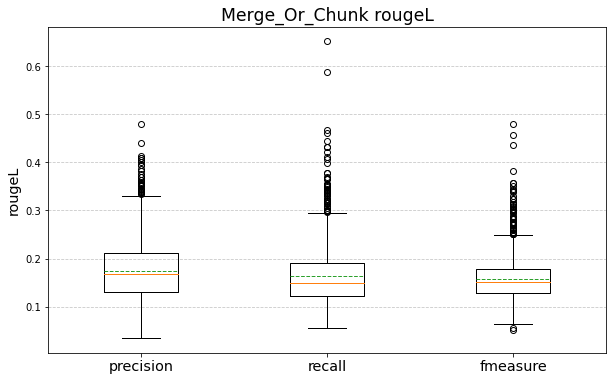

In [29]:
plot_rouge(df_moc, 'merge_or_chunk', 'rougeL')

#### Print Random Summaries

In [30]:
print_random_summaries(df_moc, RANDOM_IDS)

(9781908541994, 'ch05') chunk 1

Text:
Topical therapy. Topical therapy is useful in nearly all acne regimens. mild localized acne. moderate acne; in combination with, and following, oral
therapy. maintenance therapy; after stopping systemic agents for severe acne. Mild acne that consists of open and closed comedones and/or few
inflammatory lesions is amenable to topical therapy using agents such as salicylic acid, retinoids, azelaic acid, benzoyl peroxide (BPO) and topical
antibiotics. The use of topical antibiotics as single agents for acne is discouraged because of the potential for the development of bacterial
resistance. Topical retinoids are useful as first-line agents and topical antibiotics, when used, should be combined with BPO, ideally as a fixed-dose
combination product to enhance adherence. Topical agents differ in their efficacy against the various etiologic factors. Retinoids, azelaic acid and
BPO are effective for comedones and inflammatory acne. Topical antibiotics suc

Very similar to the baseline situation.

## **Assign Bullets**

### **Chunk Chapter (Baseline)**

#### Loading data

In [31]:
input_path = drive_dir+'summarization/baseline_output/assign_bullets/'
df_base_assign = pd.read_csv(input_path+'df_summ_'+MODEL+'.csv')
df_base_assign = df_base_assign.set_index(['book', 'chapter'])

df_base_assign.bullets = df_base_assign.bullets.map(eval)
df_base_assign.text = df_base_assign.text.map(eval)
df_base_assign.summary = df_base_assign.summary.map(eval)

#### Rouge

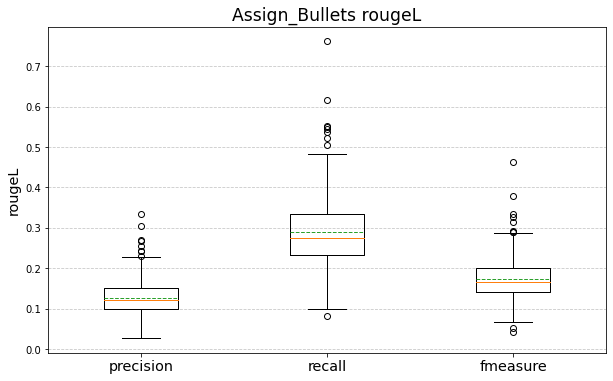

In [32]:
plot_rouge(df_base_assign, 'assign_bullets', 'rougeL', submethod='baseline')

#### Print Random Summaries

In [33]:
print_random_summaries(df_base_assign, RANDOM_IDS)

(9781908541994, 'ch05') bullet 1

Text:
Topical therapy . Topical therapy is useful in nearly all acne regimens . mild localized acne . moderate acne; in combination with, and following,
oral therapy . maintenance therapy; after stopping systemic agents for severe acne . Mild acne that consists of open and closed comedones and/or few
inflammatory lesions is amenable to topical therapy using agents such as salicylic acid, retinoids, azelaic acid, benzoyl peroxide (BPO) and topical
antibiotics . The use of topical antibiotics as single agents for acne is discouraged because of the potential for the development of bacterial
resistance . Topical retinoids are useful as first-line agents and topical antibiotics, when used, should be combined with BPO, ideally as a fixed-
dose combination product to enhance adherence . Topical agents differ in their efficacy against the various etiologic factors . Retinoids, azelaic
acid and BPO are effective for comedones and inflammatory acne . Topical ant

There are some problems coming with the method of assigning bullets:

* When the same chunk is assigned to multiple bullets, the same summary is generated, while the bullets change.
* Since one bullet is very short compared to one chunk, usually the generated summary is longer than the bullet.
* When the chunk assigned to a bullet does not contain the information present in the bullets, the summary cannot be correct.

The first and second problems can be solved by merging together bullets which have the same chunk assigned, and generating a longer summary for the chunk. Can the model understand how long the generated summary should be based on the amount of information in the chunk also present in the bullets?



### **Merge or Chunk**

#### Loading data

In [34]:
input_path = drive_dir+'summarization/moc_output/assign_bullets/'
df_moc_assign = pd.read_csv(input_path+'df_summ_'+MODEL+'.csv')
df_moc_assign = df_moc_assign.set_index(['book', 'chapter'])

df_moc_assign.bullets = df_moc_assign.bullets.map(eval)
df_moc_assign.text = df_moc_assign.text.map(eval)
df_moc_assign.summary = df_moc_assign.summary.map(eval)
df_moc_assign['merge'] = df_moc_assign['merge'].map(eval)

#### Rouge

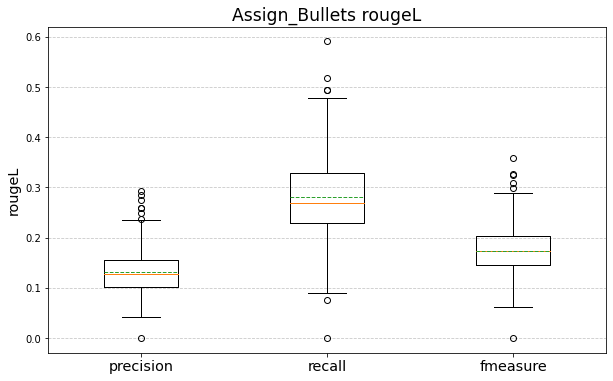

In [35]:
plot_rouge(df_moc_assign, 'assign_bullets', 'rougeL', submethod='merge_or_chunk')

#### Print Random Summaries

In [36]:
print_random_summaries(df_moc_assign, RANDOM_IDS)

(9781908541994, 'ch05') bullet 1

Text:
Topical therapy. Topical therapy is useful in nearly all acne regimens. mild localized acne. moderate acne; in combination with, and following, oral
therapy. maintenance therapy; after stopping systemic agents for severe acne. Mild acne that consists of open and closed comedones and/or few
inflammatory lesions is amenable to topical therapy using agents such as salicylic acid, retinoids, azelaic acid, benzoyl peroxide (BPO) and topical
antibiotics. The use of topical antibiotics as single agents for acne is discouraged because of the potential for the development of bacterial
resistance. Topical retinoids are useful as first-line agents and topical antibiotics, when used, should be combined with BPO, ideally as a fixed-dose
combination product to enhance adherence. Topical agents differ in their efficacy against the various etiologic factors. Retinoids, azelaic acid and
BPO are effective for comedones and inflammatory acne. Topical antibiotics su

Same as with Chunk Chapter.

### **Paragraph**

#### Loading data

In [37]:
input_path = drive_dir+'summarization/para_output/'
df_para = pd.read_csv(input_path+'df_summ_'+MODEL+'.csv')
df_para = df_para.set_index(['book', 'chapter'])

df_para.bullets = df_para.bullets.map(eval)
df_para.text = df_para.text.map(eval)
df_para.summary = df_para.summary.map(eval)

#### Rouge

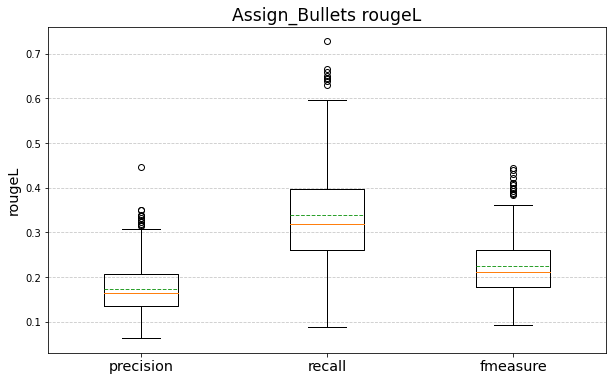

In [38]:
plot_rouge(df_para, 'assign_bullets', 'rougeL', submethod='paragraph')

#### Print Random Summaries

In [39]:
print_random_summaries(df_para, RANDOM_IDS)

(9781908541994, 'ch05') bullet 1

Text:
Topical therapy. Topical therapy is useful in nearly all acne regimens. mild localized acne. moderate acne; in combination with, and following, oral
therapy. maintenance therapy; after stopping systemic agents for severe acne. Mild acne that consists of open and closed comedones and/or few
inflammatory lesions is amenable to topical therapy using agents such as salicylic acid, retinoids, azelaic acid, benzoyl peroxide (BPO) and topical
antibiotics.

Bullets:
Topical therapy is a key component of nearly all acne regimens.

Predicted Summary:
Topical therapy is useful in nearly all acne regimens. Mild acne that consists of open and closed comedones and/or few inflammatory lesions is
amenable to topical therapy using agents such as salicylic acid, retinoids and topical antibiotics.

######################################################################################################################################################
##################

In most cases the paragraphs assigned to the bullet are very accurate and the generated summary coincide perfectly with the bullet.

However, there are some problems arising:

* Sometimes the paragraphs assigned to the bullet contain the information present in the bullet, but it is not extracted by the model. This can probably be solved with fine-tuning.
* Sometimes the paragraphs assigned to the bullet do NOT contain the information present in the bullet, this cannot be solved, as before with the chunks.
* The generated summary is less abstractive probably due to the fact that the input text is too short and does not let the model abstract key concepts.
* Using the assigned paragraphs as is can be a good enough summary of the bullet. However, in production we would not have the bullets.

## **Compare All Results**

#### Compare All Bullets Methods

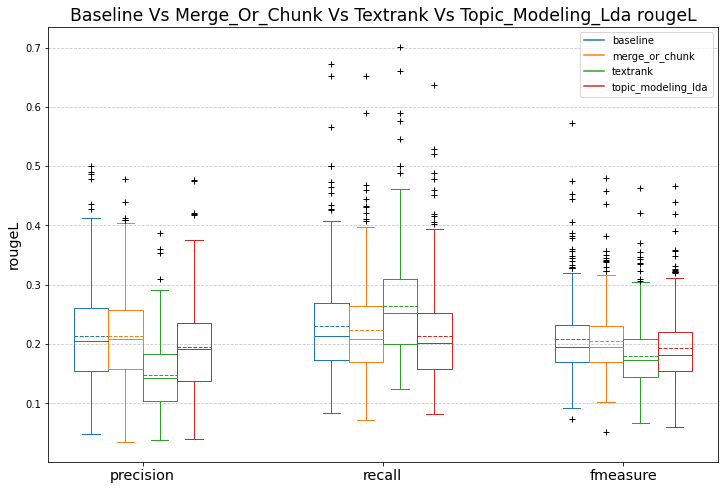

In [ ]:
plot_compare_rouge(
    [chapter_best(df_base), chapter_best(df_moc), df_tr, df_lda_summ],
    ['baseline', 'merge_or_chunk', 'textrank', 'topic_modeling_lda'],
    'rougeL')

#### Compare All Bullets and Assign Bullets

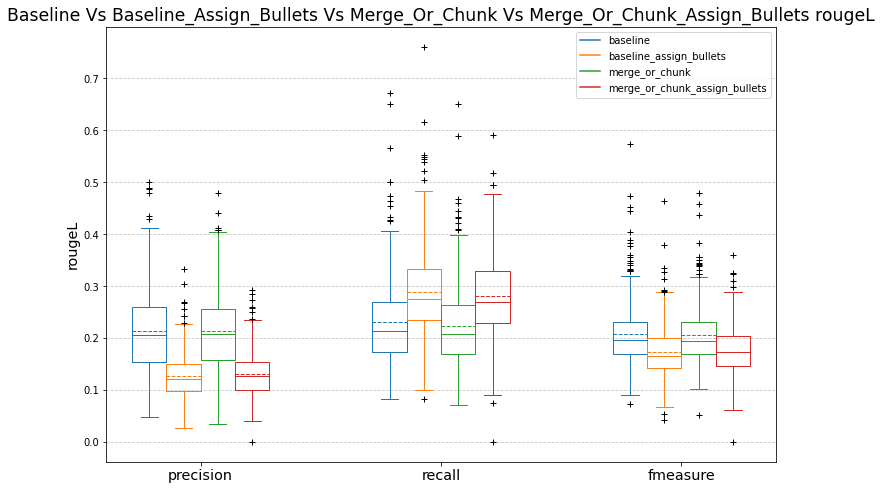

In [ ]:
plot_compare_rouge(
    [chapter_best(df_base), df_base_assign, chapter_best(df_moc), df_moc_assign],
    ['baseline', 'baseline_assign_bullets', 'merge_or_chunk', 'merge_or_chunk_assign_bullets'],
    'rougeL')

#### Compare Assign Bullets Methods

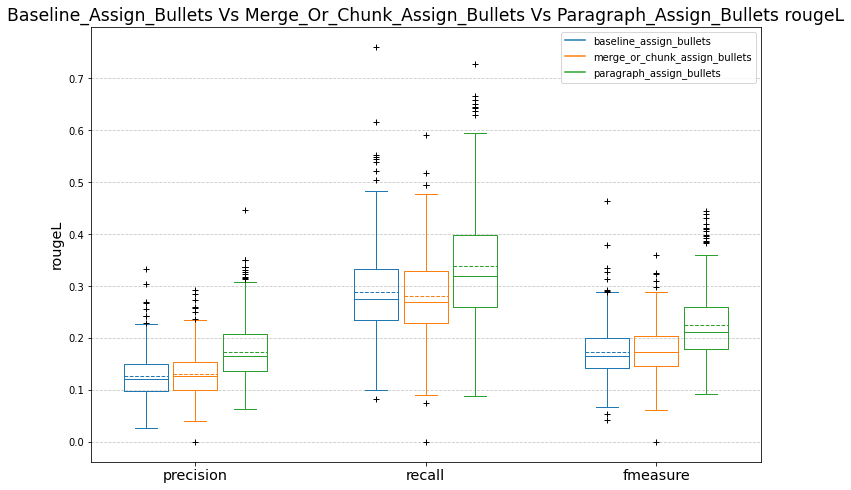

In [ ]:
plot_compare_rouge(
    [df_base_assign, df_moc_assign, df_para],
    ['baseline_assign_bullets', 'merge_or_chunk_assign_bullets', 'paragraph_assign_bullets'],
    'rougeL')

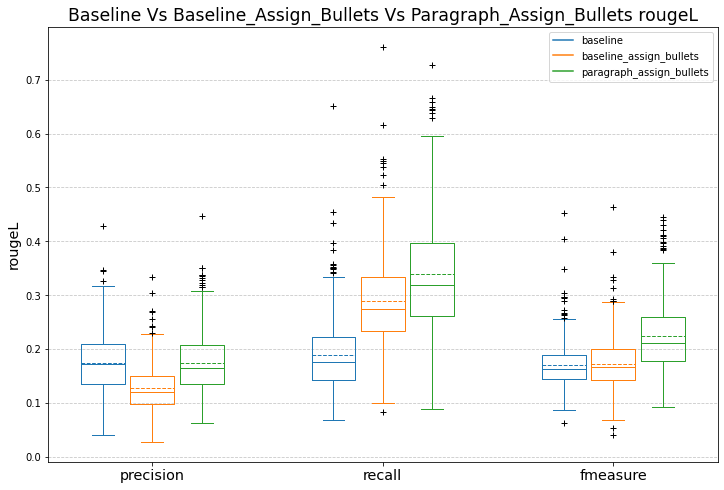

In [42]:
plot_compare_rouge(
    [chapter_avg(df_base), df_base_assign, df_para],
    ['baseline', 'baseline_assign_bullets', 'paragraph_assign_bullets'],
    'rougeL')